In [391]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt

# What are SPDR Sector Funds?


SPDR Sector funds are Exchange-traded funds (ETFs) that divide the stocks that make up the S&P 500 into 11 sectors, e.g. real estate or communications. Instead of having to select and invest in individual companies from each sector to diversify their portfolio, investors can invest in these ETFs.

Naturally, using SPDR Sector Funds is just a rough measure of sector performance since it only contains a subset of stocks that are part of the S&500. A more accurate way would be to measure the returns for all publicly traded stocks belonging to an industry sector.

Here the list of SPDR Sector funds with their corresponding symbol:

- Communication Services (XLC)
- Consumer Discretionary (XLY)
- Consumer Staples (XLP)
- Energy (XLE)
- Financials (XLF)
- Health Care (XLV)
- Industrials (XLI)
- Materials (XLB)
- Real Estate (XLRE)
- Technology (XLK)
- Utilities (XLU).

\begin{align}
sector\_ index_{t} =\sum _{i \in S}\frac{{}^iMC_{t}}{\sum _{j \in S} {}^jMC_{t}} {}^iP_{t}

\end{align}
Where $S$ is the set of all companies in the sector.


In [392]:
Code2Name={
"XLC" : "Communication Services",
"XLY" : "Consumer Discretionary",
"XLP" : "Consumer Staples",
"XLE" : "Energy",
"XLF" : "Financials",
"XLV" : "Health Care",
"XLI" : "Industrials",
"XLB" : "Materials",
"XLRE" : "Real Estate",
"XLK" : "Technology",
"XLU" : "Utilities"
}

In [393]:
SPDR=yf.download(list(Code2Name.keys()))['Adj Close']

[*********************100%***********************]  11 of 11 completed


# Analysis

In [394]:
def plot(df,start=None):
    if start is None:
        start=df.index.min()
    recessions=DataReader('USREC', 'fred', start=start)['USREC']
    fig, ax = plt.subplots(figsize=(13, 9), dpi=300)
    
    if isinstance(df,pd.DataFrame):
        ylim = (df.min().min(),df.max().max())
    else:
        ylim = (df.min(),df.max())
    df.plot(ax=ax)
    ax.fill_between(recessions.index, ylim[0]-1e-2, ylim[1]+1e-2, recessions,facecolor='k', alpha=0.1)
    fig.legend
    return fig,ax

(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

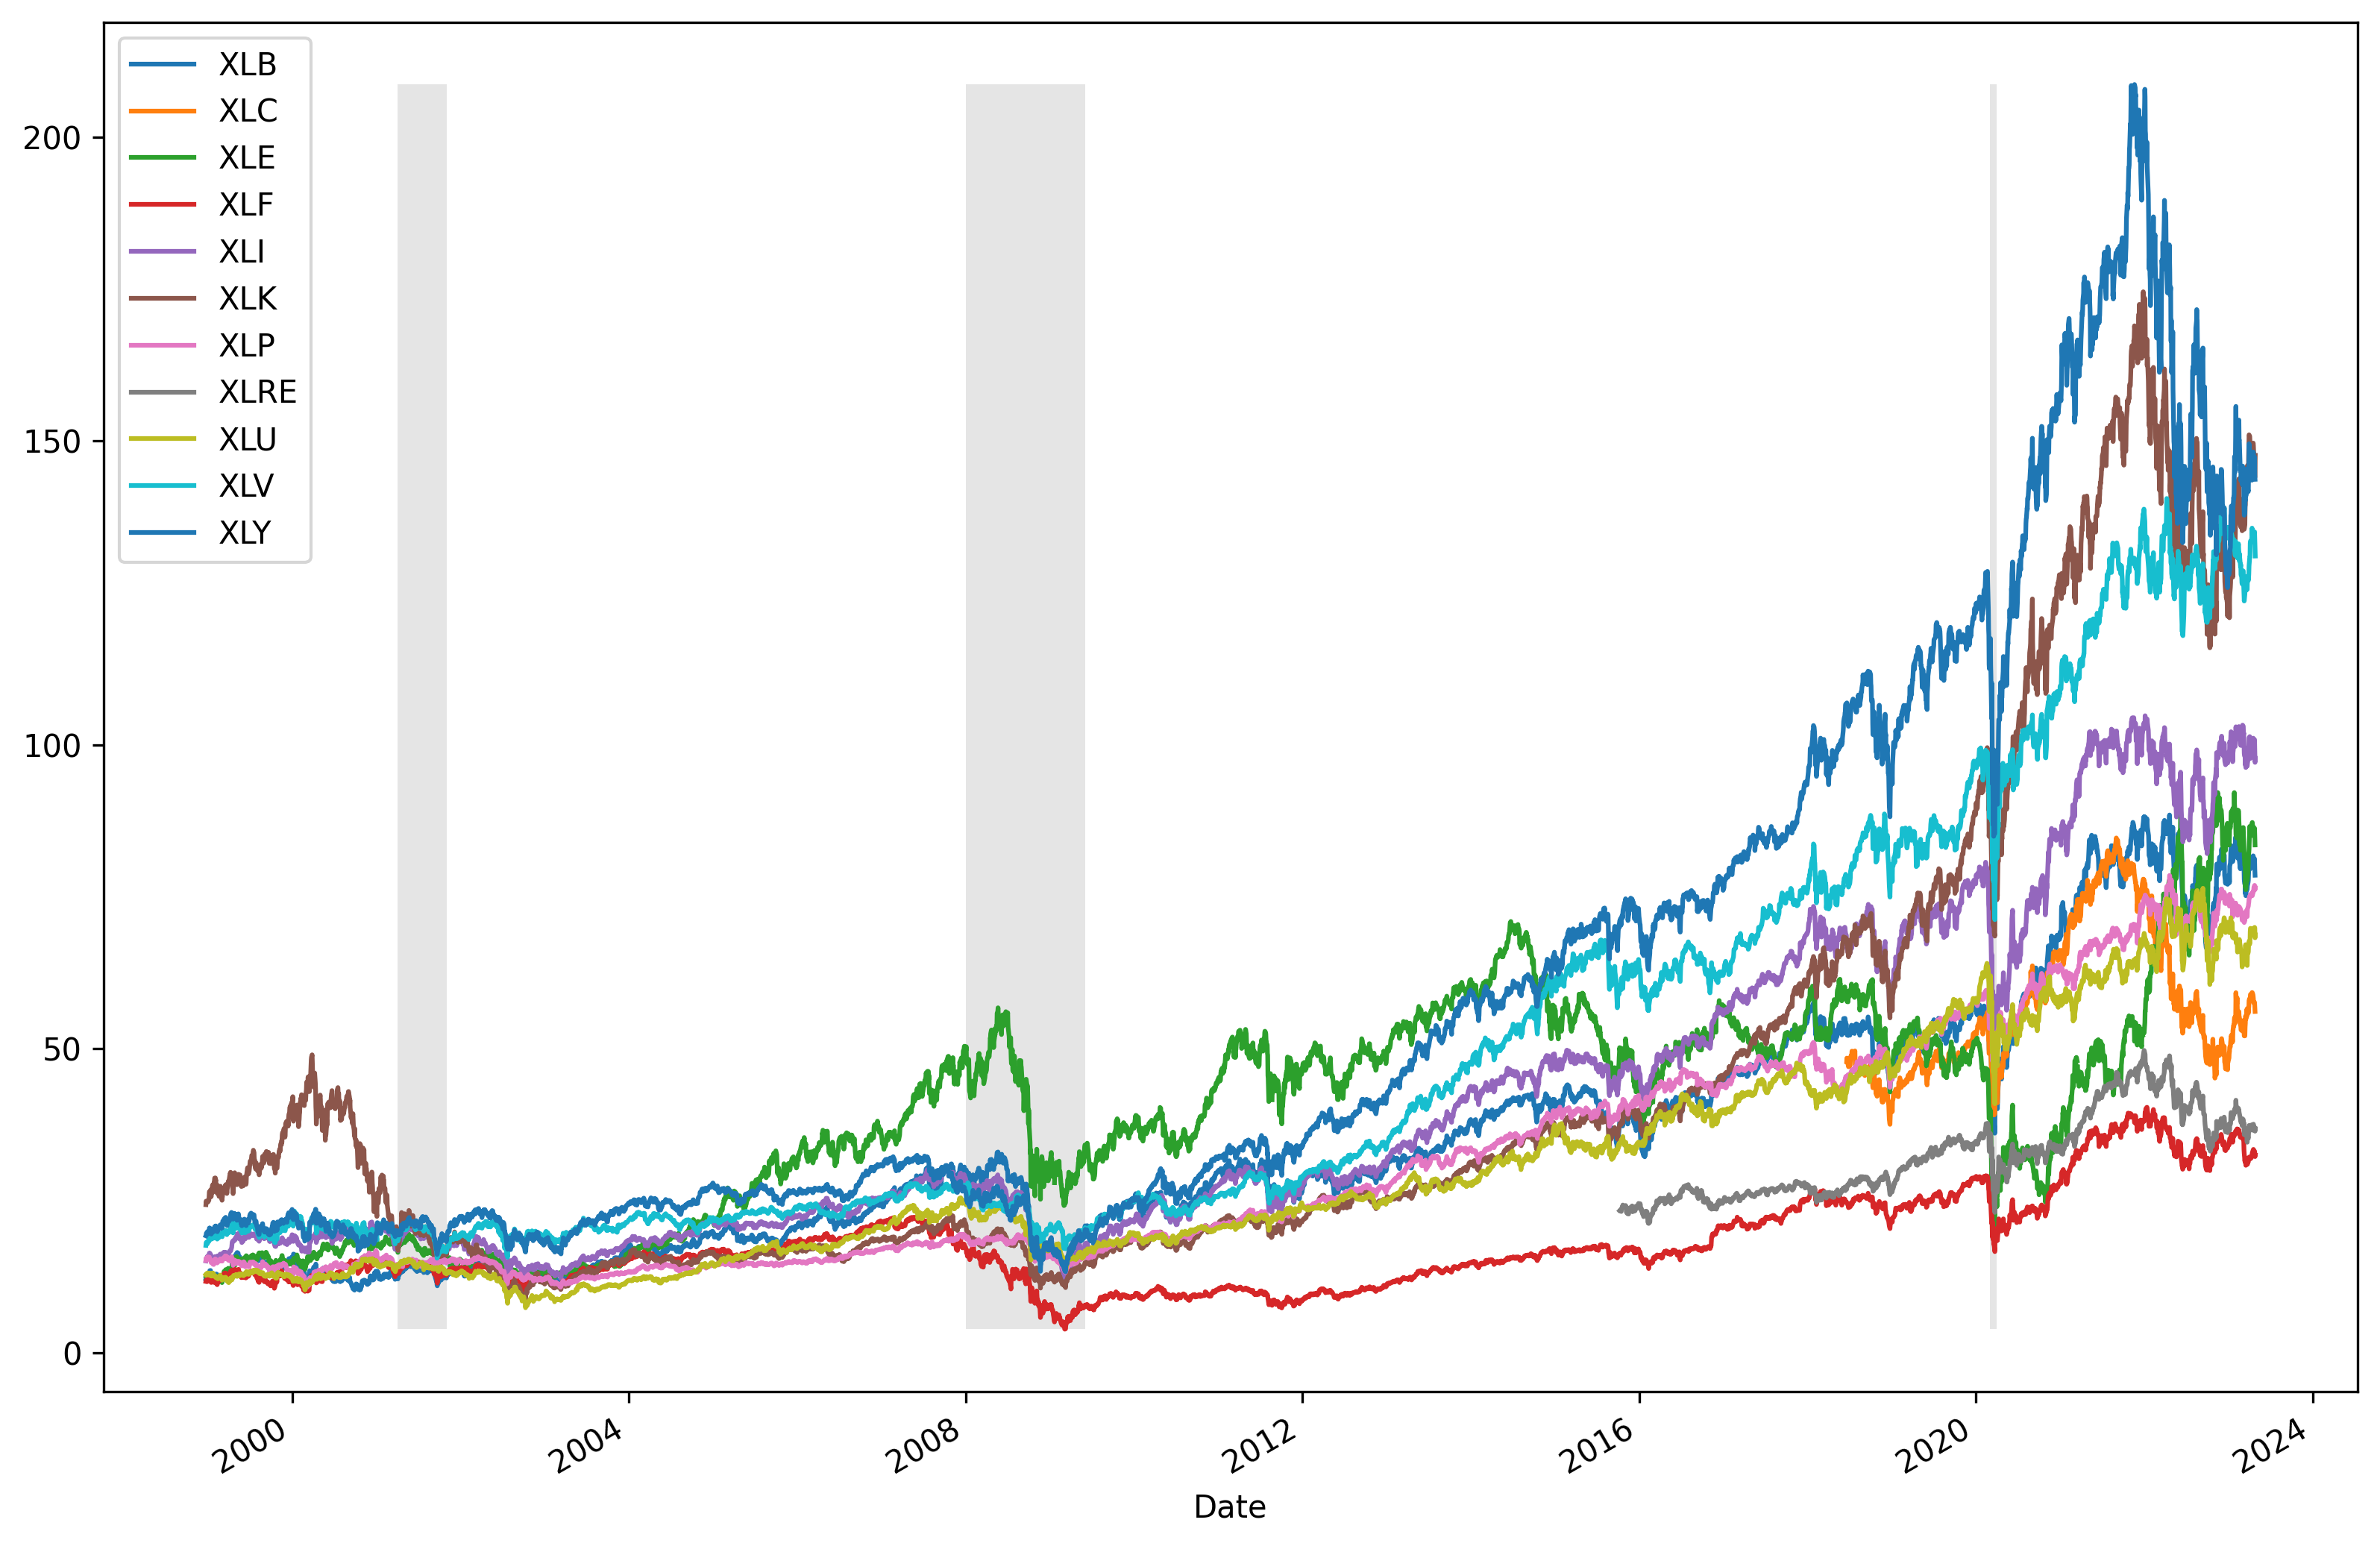

In [395]:
from pandas_datareader.data import DataReader
import matplotlib.pyplot as plt
start="1999"
recessions=DataReader('USREC', 'fred', start=start)['USREC']
df=np.log1p(SPDR)
plot(SPDR)

In [396]:
SPDR.XLC.dropna()

Date
2018-06-19    47.869732
2018-06-20    48.463783
2018-06-21    48.166756
2018-06-22    48.377552
2018-06-25    47.381062
                ...    
2023-04-20    57.549999
2023-04-21    57.689999
2023-04-24    57.630001
2023-04-25    56.730000
2023-04-26    56.130001
Name: XLC, Length: 1222, dtype: float64

In [397]:
SPDR.XLRE.dropna()

Date
2015-10-08    23.332491
2015-10-09    23.293873
2015-10-12    23.440622
2015-10-13    23.293873
2015-10-14    23.293873
                ...    
2023-04-21    37.180000
2023-04-24    37.080002
2023-04-25    36.740002
2023-04-26    36.439999
2023-04-27    36.840000
Name: XLRE, Length: 1901, dtype: float64

In [398]:
recessions = DataReader('USRECQ', 'fred', start='1999').resample('QS').last()['USRECQ'].iloc[1:]
benchmark=yf.download("^GSPC")['Adj Close'] # SP500
benchmark

[*********************100%***********************]  1 of 1 completed


Date
1927-12-30      17.660000
1928-01-03      17.760000
1928-01-04      17.719999
1928-01-05      17.549999
1928-01-06      17.660000
                 ...     
2023-04-20    4129.790039
2023-04-21    4133.520020
2023-04-24    4137.040039
2023-04-25    4071.629883
2023-04-26    4055.989990
Name: Adj Close, Length: 23944, dtype: float64

In [399]:
from dateutil.relativedelta import *

my_list=recessions.to_frame()
my_list=recessions.rolling(2).mean()
my_list=my_list[my_list==0.5]
 
recessions_start_end = []

for i in range(0, len(my_list), 2):
    recessions_start_end.append((my_list.index[i], my_list.index[i+1]))


In [400]:
def PeriodPerformance(df):
    return (df.iloc[-1]  / df.iloc[0]) -1
def MonthlyPerforamnce(df):
    return df.pct_change().resample('M').apply(lambda x: (x + 1).prod() - 1).mean()

In [401]:
stock_data=df
for start,end in recessions_start_end:
    selected_data = stock_data[(stock_data.index >= start) & (stock_data.index < end)]

In [402]:
df_perforamce=pd.DataFrame(index=pd.MultiIndex.from_tuples([(None,None)],name=('Year','Metrics')),columns=['XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLRE', 'XLU', 'XLV','XLY']).dropna()

for column in list(Code2Name.keys()):
    stock_data=SPDR.loc[:,column].copy()
    for start,end in recessions_start_end:
        selected_data = stock_data[((stock_data.index) >= start) & (stock_data.index < end)]
        selected_bench = benchmark[(benchmark.index >= start) & (benchmark.index < end)]
        
        # Calculate the performance of the stock during the selected period
        performance = PeriodPerformance(selected_data)
        bench_performance = PeriodPerformance(selected_bench)
        Monthly_avg_performance = MonthlyPerforamnce(selected_data)
        Monthly_avg_benchmark = MonthlyPerforamnce(selected_bench)
        df_perforamce.loc[(str(start.year),"Period Return (%)"),column]=performance*100
        df_perforamce.loc[(str(start.year),"Period Excess Return (%)"),column]=(performance-bench_performance)*100
        df_perforamce.loc[(str(start.year),"Average Monthly Return (%)"),column]=Monthly_avg_performance*100
        df_perforamce.loc[(str(start.year),"Monthly Excess Return (%)"),column]=(Monthly_avg_performance-Monthly_avg_benchmark)*100
df_perforamce.rename(columns=Code2Name,inplace=True)
df_perforamce

Materials Communication Services     Energy  \
Year Metrics                                                                   
2001 Period Return (%)            8.464858                    NaN -10.098083   
     Period Excess Return (%)     8.271994                    NaN -10.290946   
     Average Monthly Return (%)   1.146659                    0.0  -0.943751   
     Monthly Excess Return (%)    0.982942              -0.163718  -1.107468   
2008 Period Return (%)          -35.171977                    NaN -38.083578   
     Period Excess Return (%)     1.302222                    NaN  -1.609379   
     Average Monthly Return (%)  -1.931096                    0.0  -2.164837   
     Monthly Excess Return (%)    0.312051               2.243147    0.07831   
2020 Period Return (%)           -6.032626               0.076952 -35.303411   
     Period Excess Return (%)    -1.196306               4.913272 -30.467091   
     Average Monthly Return (%)  -0.554167               0.373831  -4.962799   
     Monthly Excess Return (%)   -0.076846               0.851152  -4.485478   

                                Financials Industrials Technology  \
Year Metrics                                                        
2001 Period Return (%)           -0.113074    5.593371  -0.826527   
     Period Excess Return (%)    -0.305937    5.400508   -1.01939   
     Average Monthly Return (%)   0.073488    0.917295   0.561601   
     Monthly Excess Return (%)   -0.090229    0.753577   0.397883   
2008 Period Return (%)          -55.421088  -40.620037 -28.773542   
     Period Excess Return (%)   -18.946889   -4.145839   7.700657   
     Average Monthly Return (%)  -3.462312   -2.427141  -1.565934   
     Monthly Excess Return (%)   -1.219165   -0.183994   0.677213   
2020 Period Return (%)          -24.436687  -16.226024  12.779861   
     Period Excess Return (%)   -19.600367  -11.389704  17.616181   
     Average Monthly Return (%)  -4.038024   -2.440249   2.343399   
     Monthly Excess Return (%)   -3.560703   -1.962928    2.82072   

                                Consumer Staples Real Estate Utilities  \
Year Metrics                                                             
2001 Period Return (%)                  5.174169         NaN  -8.67065   
     Period Excess Return (%)           4.981306         NaN -8.863513   
     Average Monthly Return (%)         0.598084         0.0 -0.951506   
     Monthly Excess Return (%)          0.434366   -0.163718 -1.115224   
2008 Period Return (%)                -15.843289         NaN -29.76183   
     Period Excess Return (%)           20.63091         NaN  6.712369   
     Average Monthly Return (%)        -0.834907         0.0 -1.766404   
     Monthly Excess Return (%)           1.40824    2.243147  0.476743   
2020 Period Return (%)                   -4.8729   -7.533292 -9.934523   
     Period Excess Return (%)           -0.03658   -2.696972 -5.098203   
     Average Monthly Return (%)        -0.704674   -0.979538 -1.473513   
     Monthly Excess Return (%)         -0.227353   -0.502217 -0.996192   

                                Health Care Consumer Discretionary  
Year Metrics                                                        
2001 Period Return (%)             2.000879              10.318895  
     Period Excess Return (%)      1.808015              10.126031  
     Average Monthly Return (%)    0.487625               1.375396  
     Monthly Excess Return (%)     0.323907               1.211678  
2008 Period Return (%)           -22.333929             -26.459869  
     Period Excess Return (%)      14.14027               10.01433  
     Average Monthly Return (%)   -1.228098              -1.298118  
     Monthly Excess Return (%)     1.015049               0.945029  
2020 Period Return (%)            -1.124386               1.354137  
     Period Excess Return (%)      3.711934               6.190457  
     Average Monthly Return (%)    0.005361               0.787841  
     Monthl

<Axes: ylabel='Year-Metrics'>

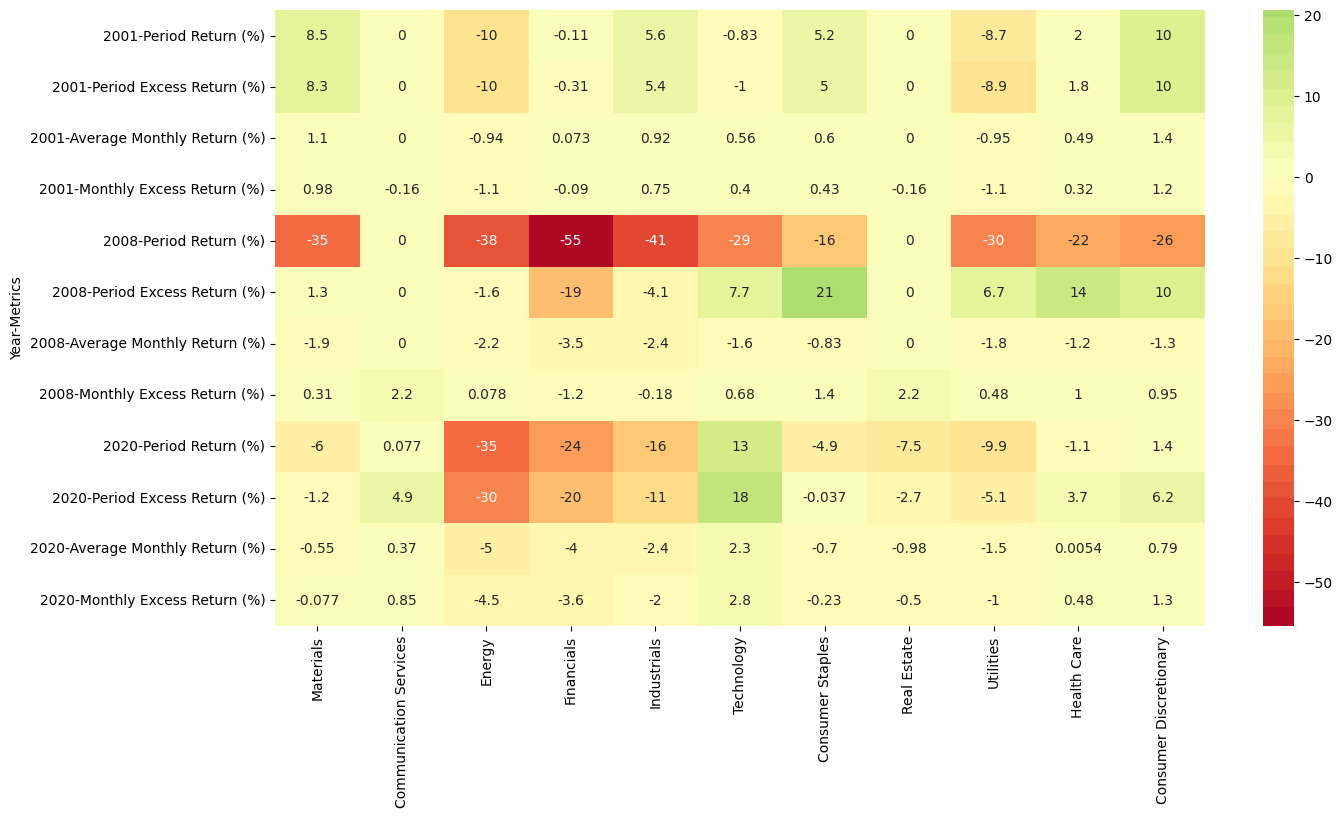

In [403]:
import seaborn as sns
palette = sns.color_palette("RdYlGn", 50)
plt.figure(figsize=(15,8))
sns.heatmap(df_perforamce.fillna(0),cmap=palette,center=0 , annot=True)

# Messing around

In [404]:
import requests,re

def extract_sector(ticker):
    url = f"https://stockanalysis.com/stocks/{ticker}/"
    response = requests.get(url)

    match= re.findall(r'(?<=<a href="/stocks/sector/communication-services/" class="dothref text-default">)[\w ]+(?=<\/a>)',response.text)
    if match:
        return match[0]
    return


extract_sector('ddd')

In [405]:
import financedatabase as fd

equities = fd.Equities()
equities_united_states = equities.select(country="United States")


In [406]:
Exchange_tickers=equities_united_states.query("sector=='Communication Services' and market!='OTC Bulletin Board'").index.to_list()

In [407]:
import os
data_folder_path='Data\Stockanalysis.com'
dfs = {}
append_count=0
# Loop through all the files in the Data folder
for filename in os.listdir(data_folder_path):
# Check if the file is a CSV file
    if filename.endswith('.csv') and ('-' in filename):
    # Get the ticker from the filename
        ticker = filename.split('-')[0].upper()
        df=pd.read_csv(os.path.join(data_folder_path,filename),index_col=0,parse_dates=True)[['Market Cap']]
        df.index=pd.DatetimeIndex(df.index)
        dfs[ticker]=df
        append_count+=1


In [408]:
Communication_Services=pd.read_csv(r'Data\Stockanalysis.com\Communication Services\Communication Services.csv',index_col=0)

In [409]:
Real_Estate=pd.read_csv(r'Data\Stockanalysis.com\Real Estate\Real Estate.csv',index_col=0,parse_dates=True)
Real_Estate

,Index
Date,
1980-03-17,0.675073
1980-03-18,0.669585
1980-03-19,0.664096
1980-03-20,0.647631
1980-03-21,0.647631
...,...
2023-04-17,128.358859
2023-04-18,128.143462
2023-04-19,128.273763


In [410]:
def Append_Price(dataframe):
    df=dataframe.copy()
    df.index= pd.DatetimeIndex(df.index)

    prices=yf.download(df.columns.get_level_values(0).to_list())['Adj Close']
    prices.columns=pd.MultiIndex.from_product([['Price'], prices.columns])

    df.columns=df.columns.swaplevel(0,1)

    data_MC_P=df.join(prices,how="outer")
    data_MC_P.index= pd.DatetimeIndex(data_MC_P.index)
    return data_MC_P.loc[:'2023-04-01']

In [411]:
data_MC_P=Append_Price(Communication_Services[list((set(Communication_Services.columns.get_level_values(0)) & set(Exchange_tickers)) - set(['COMS']))])


[*********************100%***********************]  160 of 160 completed

1 Failed download:
- TWTR: No timezone found, symbol may be delisted


In [412]:
data_MC_P[('Price','TWTR')]=pd.read_csv(r'Data\twtr-chart.csv',parse_dates=True,index_col=0)['Close']

<Axes: xlabel='Date'>

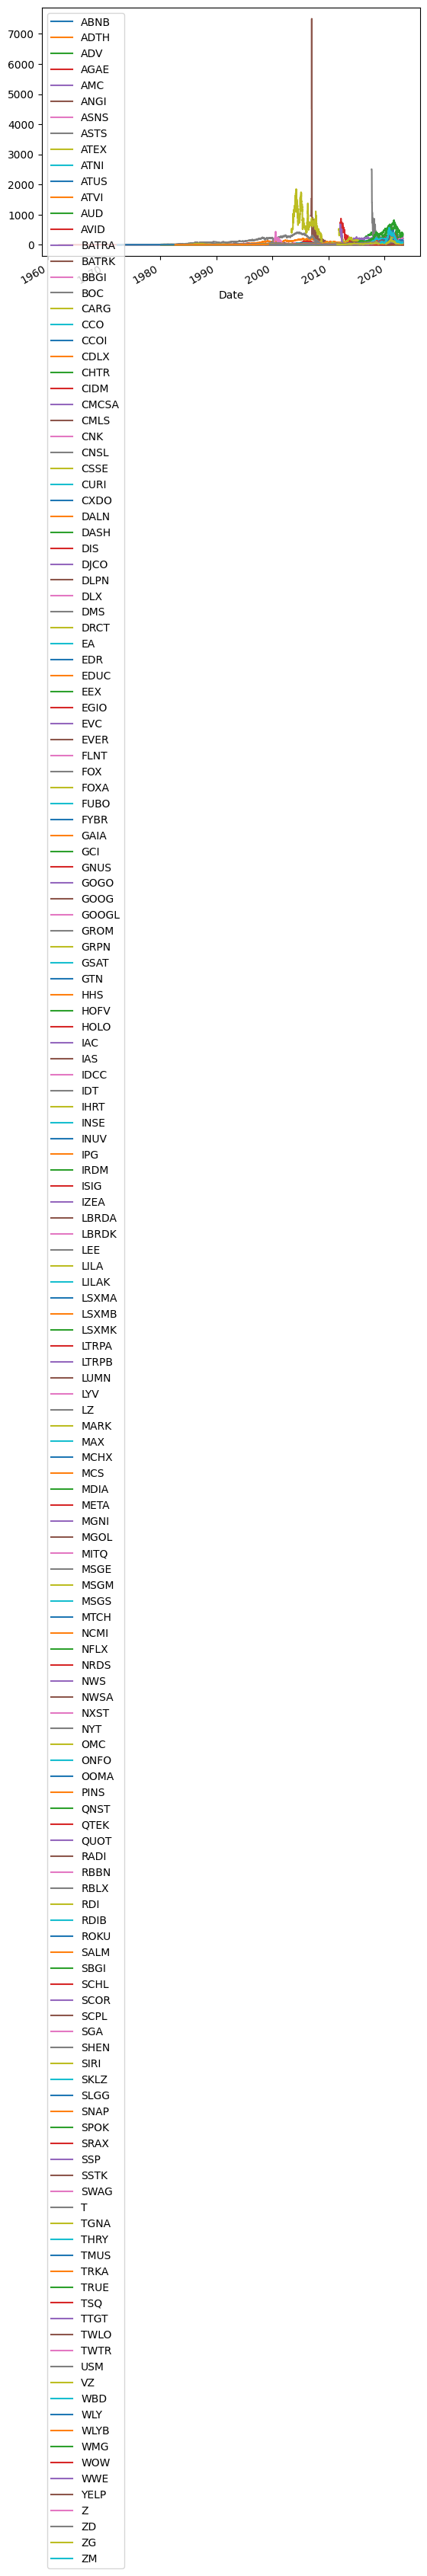

In [413]:
data_MC_P['Price'].plot()

In [414]:
equities_united_states.loc[['COMS']]

,name,summary,currency,sector,industry_group,industry,exchange,market,country,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
symbol,,,,,,,,,,,,,,,,,,,
COMS,COMSovereign Holding Corp.,"ComSovereign Holding Corp. designs, develops, ...",USD,Communication Services,Telecommunication Services,Diversified Telecommunication Services,NCM,NASDAQ Capital Market,United States,TX,Dallas,75254,http://www.comsovereign.com,Nano Cap,NaN,NaN,NaN,NaN,NaN


In [415]:
data_MC_P['Price'].max().sort_values(ascending=False).index.to_list()

['DLPN',
 'GROM',
 'MARK',
 'GNUS',
 'CHTR',
 'NFLX',
 'IZEA',
 'ZM',
 'GRPN',
 'ROKU',
 'TWLO',
 'RBBN',
 'LEE',
 'DJCO',
 'META',
 'MSGM',
 'HOFV',
 'DASH',
 'MSGS',
 'ABNB',
 'NXST',
 'HHS',
 'ZG',
 'DIS',
 'Z',
 'LBRDK',
 'LBRDA',
 'MTCH',
 'IAC',
 'CDLX',
 'TMUS',
 'GOOG',
 'GOOGL',
 'EA',
 'CIDM',
 'RBLX',
 'ZD',
 'LYV',
 'SSTK',
 'TTGT',
 'USM',
 'ATVI',
 'YELP',
 'WWE',
 'OMC',
 'PINS',
 'IDCC',
 'SNAP',
 'ATNI',
 'CCOI',
 'TWTR',
 'WBD',
 'LTRPB',
 'AVID',
 'IDT',
 'LILAK',
 'ATEX',
 'IRDM',
 'SCOR',
 'DLX',
 'MAX',
 'EVER',
 'AMC',
 'FUBO',
 'WLY',
 'MGNI',
 'WLYB',
 'INUV',
 'SIRI',
 'CMCSA',
 'LSXMB',
 'CARG',
 'LSXMA',
 'LSXMK',
 'NYT',
 'VZ',
 'SBGI',
 'WMG',
 'BOC',
 'LILA',
 'SCHL',
 'AUD',
 'CSSE',
 'FLNT',
 'SKLZ',
 'MCS',
 'FOXA',
 'THRY',
 'ISIG',
 'SGA',
 'CNK',
 'FOX',
 'RDI',
 'LZ',
 'IPG',
 'SHEN',
 'LTRPA',
 'ATUS',
 'BATRA',
 'BATRK',
 'RDIB',
 'FYBR',
 'EDR',
 'GOGO',
 'QUOT',
 'GAIA',
 'NRDS',
 'TGNA',
 'ANGI',
 'IHRT',
 'NWSA',
 'IAS',
 'NWS',
 'QNST',
 'GT

In [385]:
def Make_Index(data_MC_P):
    data_MC_P_test=data_MC_P.copy()
    data_MC_P_test.fillna(0,inplace=True)
    TotalMC=data_MC_P_test['Market Cap'].sum(axis=1)
    
    W=data_MC_P_test['Market Cap'].apply(
                                     lambda x: np.asarray(x) * 1/np.asarray(TotalMC)
                                     )
    index=(data_MC_P_test['Price']*W).sum(axis=1).to_frame('Index')
    index=index.loc[~(index==0).all(axis=1)]
    return index,W

In [389]:
index,W=Make_Index(data_MC_P)

C:\Users\amine\AppData\Local\Temp\ipykernel_4268\3022476493.py:7: RuntimeWarning: invalid value encountered in divide
  lambda x: np.asarray(x) * 1/np.asarray(TotalMC)


,Index
Date,
1983-08-15,1.106086
1983-08-16,1.106086
1983-08-17,1.106086
1983-08-18,1.106086
1983-08-19,1.121640
...,...
2023-03-27,111.684568
2023-03-28,110.237279
2023-03-29,111.811618


(<Figure size 3900x2700 with 1 Axes>, <Axes: xlabel='Date'>)

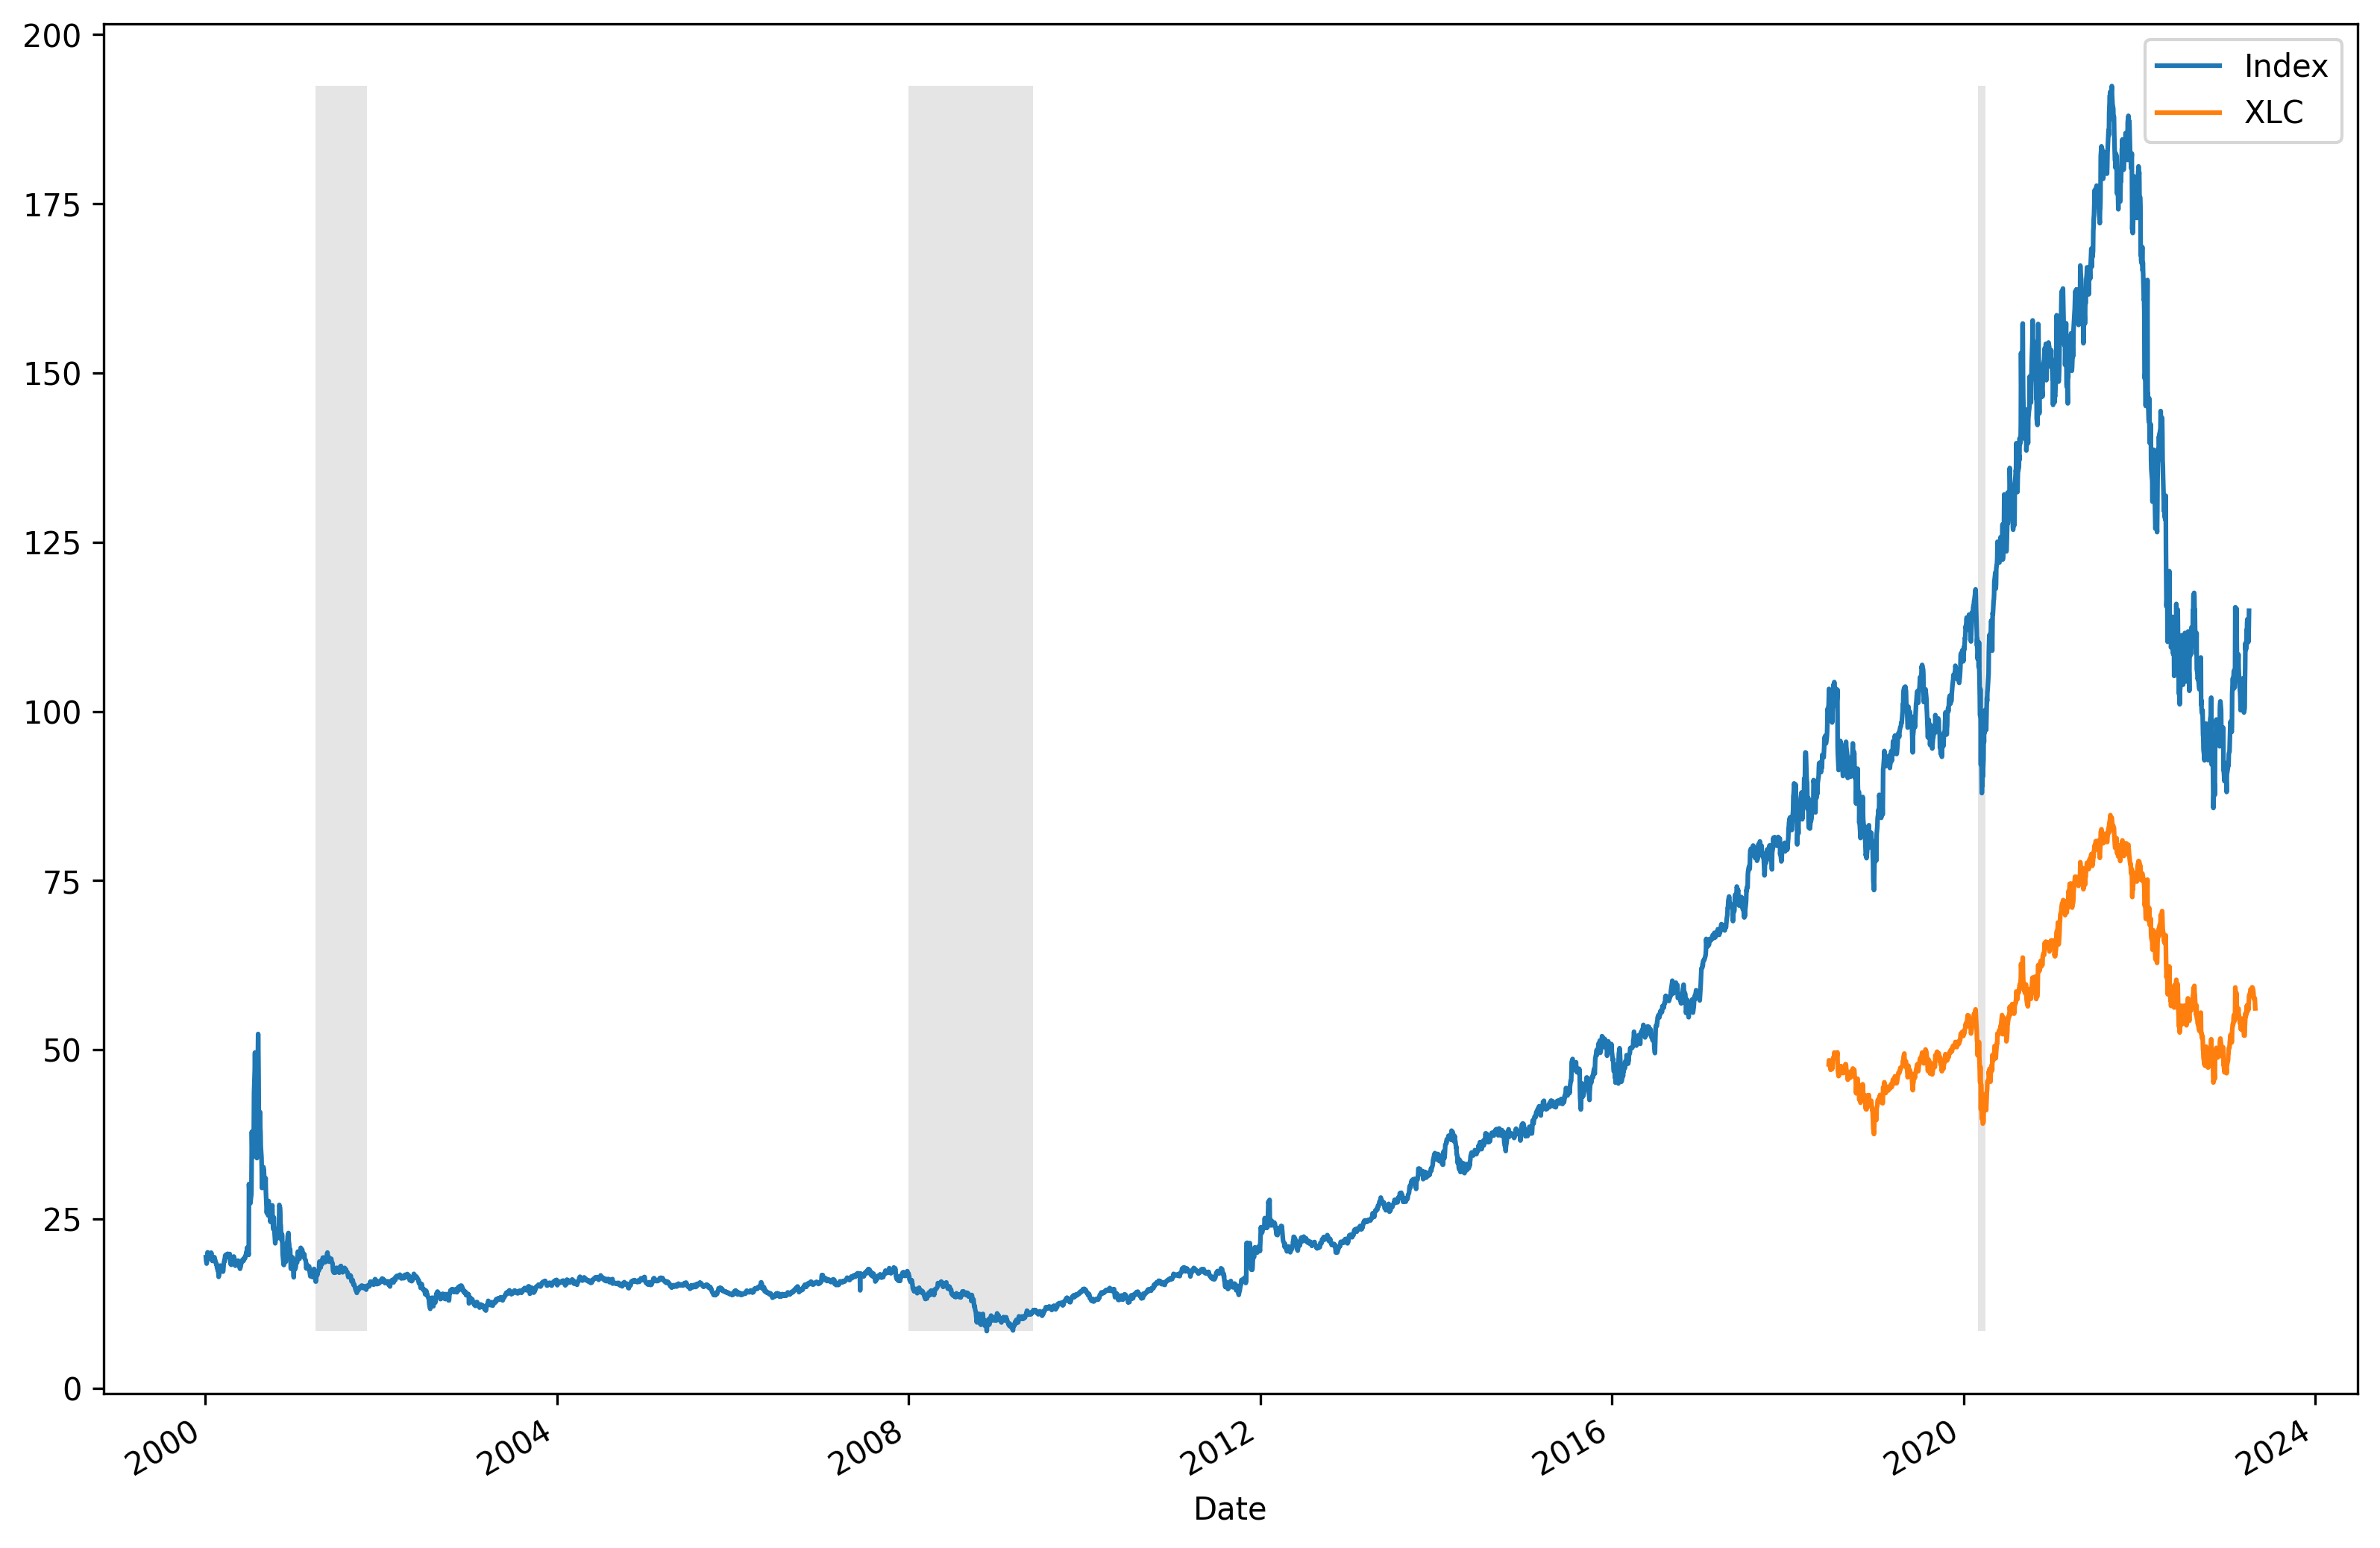

In [390]:
plot(pd.concat([index,SPDR['XLC']],axis=1).loc["2000":])